# SHAP Attribution Drift Over Engine Life
This notebook explores how SHAP feature importances change with Remaining Useful Life (RUL) progression. It helps uncover which sensors become more or less important as the engine degrades.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/processed/cmapss_fd004_preprocessed.csv')
sensor_cols = [col for col in df.columns if 'sensor_' in col]
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

window_size = 50
class RULDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.sequences = []
        self.targets = []
        units = df['unit'].unique()
        for unit in units:
            unit_df = df[df['unit'] == unit].reset_index(drop=True)
            for i in range(len(unit_df) - window_size):
                seq = unit_df.loc[i:i+window_size-1, sensor_cols].values
                rul = unit_df.loc[i+window_size-1, 'RUL']
                self.sequences.append(seq)
                self.targets.append(rul)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

# Model class (same as before)
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Load model
model = LSTMModel(input_size=len(sensor_cols)).to(device)
model.load_state_dict(torch.load('../data/processed/lstm_rul_model.pth', map_location=device))
model.eval()

LSTMModel(
  (lstm): LSTM(21, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [3]:
# Prepare RUL bins and SHAP aggregation
dataset = RULDataset(df)
unit_ids = df['unit'].unique()

rul_bins = [0, 20, 40, 60, 80, 100, 150, 200]
bin_names = [f"{rul_bins[i]}-{rul_bins[i+1]}" for i in range(len(rul_bins)-1)]
shap_by_bin = {bn: [] for bn in bin_names}

for i in range(0, len(dataset), 50):  # sample windows
    x, y = dataset[i]
    x = x.unsqueeze(0).to(device)
    y = y.item()
    explainer = shap.GradientExplainer(model, x)
    shap_values = explainer.shap_values(x)[0]  # (1, 50, num_features)
    shap_mean = np.abs(shap_values).mean(axis=(0,1))  # mean over time

    for b_start, b_end in zip(rul_bins[:-1], rul_bins[1:]):
        if b_start < y <= b_end:
            shap_by_bin[f"{b_start}-{b_end}"].append(shap_mean)
            break

# Aggregate
avg_importance_by_bin = {}
for bin_name, vals in shap_by_bin.items():
    if vals:
        avg_importance_by_bin[bin_name] = np.mean(np.array(vals), axis=0)
    else:
        avg_importance_by_bin[bin_name] = np.zeros(len(sensor_cols))

shap_drift_df = pd.DataFrame(avg_importance_by_bin, index=sensor_cols).T

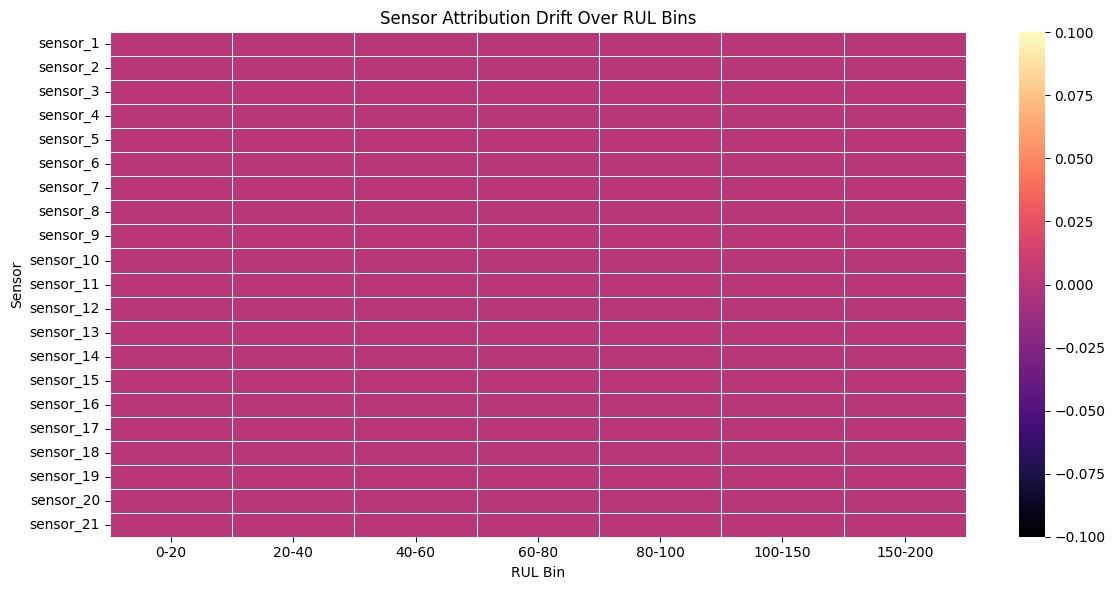

In [4]:
plt.figure(figsize=(12,6))
sns.heatmap(shap_drift_df.T, annot=False, cmap='magma', linewidths=0.5)
plt.title('Sensor Attribution Drift Over RUL Bins')
plt.xlabel('RUL Bin')
plt.ylabel('Sensor')
plt.tight_layout()
plt.show()